# **Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series**

**Nama : Muhammad Alfariza Rasendria**

Email : rasendria.alfariza18@gmail.com

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle'

In [ ]:
!kaggle datasets download -d amandam1/walmart-stock-20122016 --force

100% 223k/223k [00:00<00:00, 766kB/s]
100% 223k/223k [00:00<00:00, 765kB/s]


In [ ]:
import zipfile

file_path = '/content/walmart-stock-20122016.zip'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/tmp/')

In [ ]:
base_dir = '/tmp'

In [ ]:
df = pd.read_csv(f'{base_dir}/WMT.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-08-25,0.063477,0.064697,0.063477,0.064453,0.036175,2508800
1,1972-08-28,0.064453,0.064941,0.064209,0.064209,0.036038,972800
2,1972-08-29,0.063965,0.063965,0.063477,0.063477,0.035627,1945600
3,1972-08-30,0.063477,0.063477,0.062988,0.063477,0.035627,409600
4,1972-08-31,0.062988,0.062988,0.062500,0.062500,0.035079,870400


In [ ]:
df.shape

(12566, 7)

In [ ]:
df.isnull().sum()
df['Open']

0          0.063477
1          0.064453
2          0.063965
3          0.063477
4          0.062988
            ...    
12561    120.019997
12562    118.300003
12563    122.099998
12564    121.750000
12565    124.089996
Name: Open, Length: 12566, dtype: float64

In [ ]:
df = df[['Date','Open']]

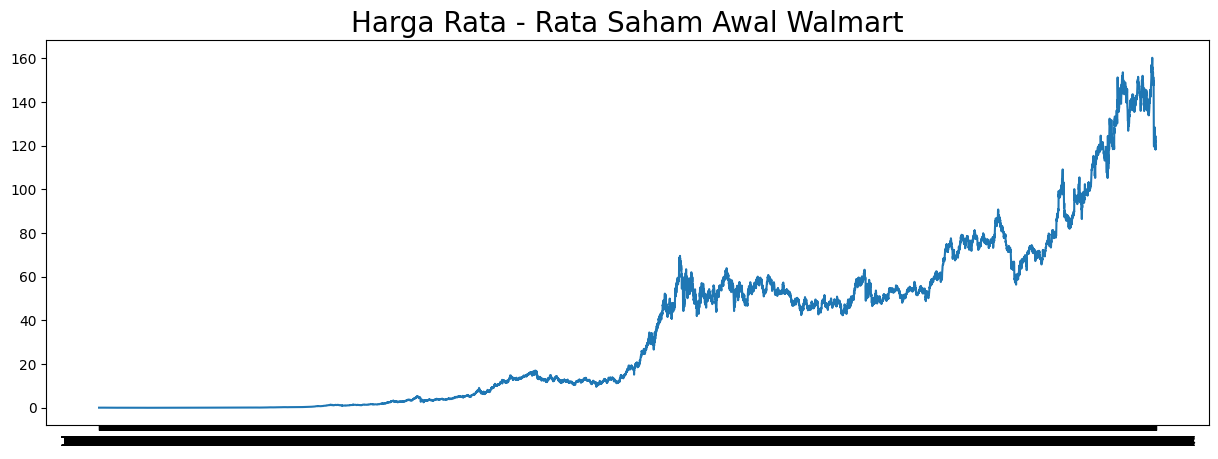

In [ ]:
dates = df['Date'].values
open_prices  = df['Open'].values


plt.figure(figsize=(15,5))
plt.plot(dates, open_prices)
plt.title('Harga Rata - Rata Saham Awal Walmart',
          fontsize=20);

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def reshape_column_to_2d(df, column_name):
    column_data = df[column_name].values.reshape(-1, 1)
    min_max_scaler = MinMaxScaler()
    column_normalized = min_max_scaler.fit_transform(column_data)
    return column_normalized

open_prices = reshape_column_to_2d(df, 'Open')
open_prices.shape

(12566, 1)

In [ ]:
open_prices

array([[2.98637543e-04],
       [3.04728620e-04],
       [3.01683081e-04],
       ...,
       [7.61911250e-01],
       [7.59726962e-01],
       [7.74330545e-01]])

In [ ]:
threshold_mae = (open_prices.max() - open_prices.min()) * 10/100
threshold_mae

0.1

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
from sklearn.model_selection import train_test_split
train_dates, val_dates, train_open_prices, val_open_prices = train_test_split(dates, open_prices, test_size=0.2, shuffle=False)

In [ ]:
train_set = windowed_dataset(train_open_prices, window_size=100, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(val_open_prices, window_size=100, batch_size=100, shuffle_buffer=1000)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(100, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128,return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1),
])


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
class CustomCallbackClass(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(CustomCallbackClass, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('mae') < self.threshold:
            print("\nMAE telah kurang dari 10% skala data, sehingga training model dihentikan.")
            self.model.stop_training = True

In [ ]:
mae_threshold_callback = CustomCallbackClass(threshold_mae)

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100, validation_data=val_set, callbacks=[early_stopping,mae_threshold_callback], verbose=1)

Epoch 1/100
100/100 [==============================] - 12s 68ms/step - loss: 0.0178 - mae: 0.1292 - val_loss: 0.1769 - val_mae: 0.5691
Epoch 2/100
100/100 [==============================] - 4s 40ms/step - loss: 0.0139 - mae: 0.1161 - val_loss: 0.1560 - val_mae: 0.5314
Epoch 3/100
100/100 [==============================] - 5s 47ms/step - loss: 0.0116 - mae: 0.1129 - val_loss: 0.1412 - val_mae: 0.5031
Epoch 4/100
100/100 [==============================] - 5s 47ms/step - loss: 0.0104 - mae: 0.1116 - val_loss: 0.1308 - val_mae: 0.4825
Epoch 5/100
100/100 [==============================] - 5s 45ms/step - loss: 0.0097 - mae: 0.1125 - val_loss: 0.1233 - val_mae: 0.4671
Epoch 6/100
100/100 [==============================] - 6s 58ms/step - loss: 0.0092 - mae: 0.1134 - val_loss: 0.1176 - val_mae: 0.4552
Epoch 7/100
100/100 [==============================] - 4s 40ms/step - loss: 0.0088 - mae: 0.1137 - val_loss: 0.1131 - val_mae: 0.4455
Epoch 8/100
100/100 [==============================] - 4s 40m

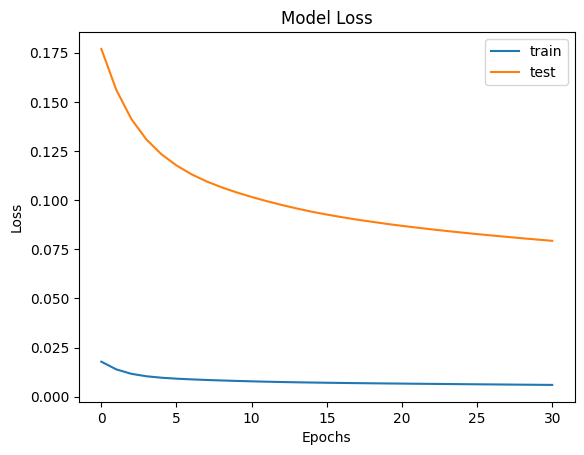

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

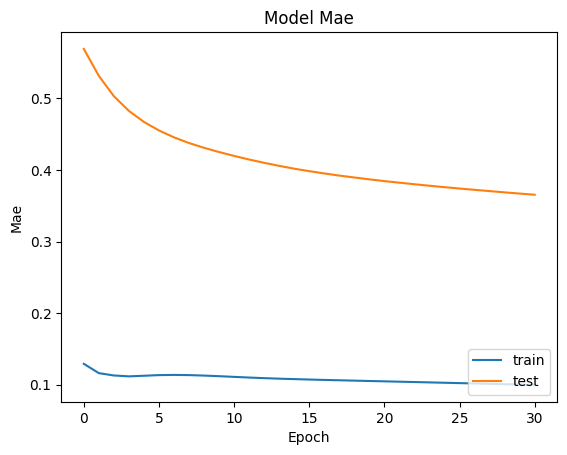

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()